In [ ]:
import torch
import torch.nn as nn
from modules import (
    SEANetEncoder, 
    SEANetDecoder, 
    SEANetResnetBlock,
    SConv1d, 
    SConvTranspose1d, 
    SLSTM
)
# from quantization.core_vq import ResidualVectorQuantizer, QuantizedResult
from quantization import (
    QuantizedResult, 
    ResidualVectorQuantizer
)

class QuantizedAutoencoder(nn.Module):
    def __init__(self, channels=1, dimension=128, n_filters=32, n_residual_layers=1,
                 ratios=[8, 5, 4, 2], activation='ELU', norm='weight_norm',
                 vq_dimension=128, n_q=8, bins=1024, decay=0.99, kmeans_init=True, 
                 kmeans_iters=50, threshold_ema_dead_code=2):
        super().__init__()
        self.encoder = SEANetEncoder(
            channels=channels,
            dimension=dimension,
            n_filters=n_filters,
            n_residual_layers=n_residual_layers,
            ratios=ratios,
            activation=activation,
            norm=norm
        )
        self.decoder = SEANetDecoder(
            channels=channels,
            dimension=dimension,
            n_filters=n_filters,
            n_residual_layers=n_residual_layers,
            ratios=ratios,
            activation=activation,
            norm=norm
        )
        self.vq = ResidualVectorQuantizer(
            dimension=vq_dimension,
            n_q=n_q,
            bins=bins,
            decay=decay,
            kmeans_init=kmeans_init,
            kmeans_iters=kmeans_iters,
            threshold_ema_dead_code=threshold_ema_dead_code
        )

    def forward(self, x):
        encoded = self.encoder(x)
        quantized_result = self.vq(encoded, frame_rate=75)  # frame_rate can be adjusted as per your data
        quantized = quantized_result.quantized
        decoded = self.decoder(quantized)
        return decoded, quantized_result

# Example instantiation
model = QuantizedAutoencoder(channels=1, dimension=128, n_filters=32, n_residual_layers=1)


# Train Script

In [ ]:
import os
import torch
import torchaudio
import numpy as np
import random

import torch
import torch.nn as nn
from modules import (
    SEANetEncoder, 
    SEANetDecoder, 
    SEANetResnetBlock,
    SConv1d, 
    SConvTranspose1d, 
    SLSTM
)
from quantization import (
    QuantizedResult, 
    ResidualVectorQuantizer
)

class QuantizedAutoencoder(nn.Module):
    def __init__(self, channels=1, dimension=128, n_filters=32, n_residual_layers=1,
                 ratios=[8, 5, 4, 2], activation='ELU', norm='weight_norm',
                 vq_dimension=128, n_q=32, bins=1024, decay=0.99, kmeans_init=True, 
                 kmeans_iters=50, threshold_ema_dead_code=2):
        """
        Initializes the QuantizedAutoencoder with the given parameters.

        Parameters:
        - channels (int): Number of input channels (default is 1 for mono audio).
        - dimension (int): Dimension of the latent space.
        - n_filters (int): Number of filters in the convolutional layers.
        - n_residual_layers (int): Number of residual layers in the encoder and decoder.
        - ratios (list): List of downsampling ratios for the encoder.
        - activation (str): Activation function to use (default is 'ELU').
        - norm (str): Normalization technique to use (default is 'weight_norm').
        - vq_dimension (int): Dimension of the vectors in the quantizer.
        - n_q (int): Number of codebooks in the quantizer.
        - bins (int): Number of bins (codebook vectors) in each codebook.
        - decay (float): Decay rate for exponential moving average in quantizer.
        - kmeans_init (bool): Whether to use K-means initialization for the quantizer.
        - kmeans_iters (int): Number of iterations for K-means initialization.
        - threshold_ema_dead_code (int): Threshold for the exponential moving average of dead codes.
        """
        super().__init__()
        
        # Initialize the encoder part of the autoencoder
        self.encoder = SEANetEncoder(
            channels=channels,
            dimension=dimension,
            n_filters=n_filters,
            n_residual_layers=n_residual_layers,
            ratios=ratios,
            activation=activation,
            norm=norm
        )
        
        # Initialize the decoder part of the autoencoder
        self.decoder = SEANetDecoder(
            channels=channels,
            dimension=dimension,
            n_filters=n_filters,
            n_residual_layers=n_residual_layers,
            ratios=ratios,
            activation=activation,
            norm=norm
        )
        
        # Initialize the Residual Vector Quantizer
        self.vq = ResidualVectorQuantizer(
            dimension=vq_dimension,
            n_q=n_q,
            bins=bins,
            decay=decay,
            kmeans_init=kmeans_init,
            kmeans_iters=kmeans_iters,
            threshold_ema_dead_code=threshold_ema_dead_code
        )

    def forward(self, x):
        """
        Forward pass of the QuantizedAutoencoder.

        Parameters:
        - x (Tensor): Input tensor of shape (batch_size, channels, sequence_length).

        Returns:
        - decoded (Tensor): Reconstructed output tensor of shape (batch_size, channels, sequence_length).
        - quantized_result (QuantizedResult): Contains the quantized representation and additional quantization info.
        """
        # Pass the input through the encoder to get the encoded representation
        encoded = self.encoder(x)
        
        # Quantize the encoded representation using the Residual Vector Quantizer
        quantized_result = self.vq(encoded, frame_rate=75)  # frame_rate can be adjusted as per your data
        
        # Extract the quantized tensor from the quantized result
        quantized = quantized_result.quantized
        
        # Pass the quantized tensor through the decoder to get the reconstructed output
        decoded = self.decoder(quantized)
        
        # Return the reconstructed output and the quantized result
        return decoded, quantized_result


# Example instantiation
model = QuantizedAutoencoder(channels=1, dimension=128, n_filters=32, n_residual_layers=1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import soundfile as sf
import librosa.filters

class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        sampling_rate=22050,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=None,
        device='cuda'  # Default device is set to 'cuda'
    ):
        super().__init__()
        self.device = device  # Store the device to ensure consistency
        self.win_length = win_length
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.window = torch.hann_window(win_length, device=self.device).float()

        # Create the mel filterbank
        mel_basis = librosa.filters.mel(
            sr=sampling_rate,
            n_fft=n_fft,
            n_mels=n_mel_channels,
            fmin=mel_fmin,
            fmax=mel_fmax
        )
        self.mel_basis = torch.from_numpy(mel_basis).to(self.device).float()

    def forward(self, audio):
        # Ensure input is on the correct device
        audio = audio.to(self.device)

        # Padding
        p = (self.n_fft - self.hop_length) // 2
        audio_padded = F.pad(audio, (p, p), "reflect").squeeze(1)

        # Compute the short-time Fourier transform (STFT)
        fft = torch.stft(
            audio_padded,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
            return_complex=True
        )

        # Power spectrum
        power = torch.abs(fft)**2

        # Apply mel filterbank
        mel_output = torch.matmul(self.mel_basis, power)
        
        # Log scale
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        
        return log_mel_spec

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
seed = int(torch.randint(1, 1000, (1,))[0])
set_seed(seed)

class WavDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_paths = []
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.endswith('.wav'):
                    self.file_paths.append(os.path.join(dirpath, filename))
        self.transform = transform
        self.sample_rate = 24000  # Assuming all files have a sample rate of 24000 Hz

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform, _ = torchaudio.load(file_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Apply any necessary preprocessing or transformation
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform

datadir = "data/"
train_dataset = WavDataset(datadir + "train24khz")
val_dataset = WavDataset(datadir + "val24khz")
test_dataset = WavDataset(datadir + "test24khz")

import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming a model and loss function are defined elsewhere
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QuantizedAutoencoder(channels=1, dimension=128, n_filters=32, n_residual_layers=1).to(device)


def total_loss(wav1, wav2, sample_rate=24000):
    """
    Computes the total loss between two waveforms, combining L1 and L2 losses on both raw audio and mel spectrograms.

    Parameters:
    - wav1 (Tensor): First waveform tensor.
    - wav2 (Tensor): Second waveform tensor.
    - sample_rate (int): Sampling rate of the audio.

    Returns:
    - loss (Tensor): The computed total loss.
    """
    l1Loss = torch.nn.L1Loss(reduction='mean')
    l2Loss = torch.nn.MSELoss(reduction='mean')
    
    # Initialize loss as a zero tensor with gradient tracking
    loss = torch.tensor(0.0, device=wav1.device, requires_grad=True)

    # Loop over a set of parameters for mel transformation
    for i in range(8, 9):
        fft = Audio2Mel(win_length=2 ** i, hop_length=2 ** i // 4, n_mel_channels=64, sampling_rate=sample_rate)
        mel1 = fft(wav1)
        mel2 = fft(wav2)
        
        # Add L1 and L2 loss for the mel spectrograms
        loss = loss + l1Loss(mel1, mel2) + l2Loss(mel1, mel2)

    # Add L1 loss for the raw audio
    loss = loss + l1Loss(wav1, wav2)

    return loss


sample_rate = 24000

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
val_losses = []
test_losses = []

num_epochs = 40
t_half = 10  # Evaluate and potentially change the learning rate every 5 epochs

batch_size = 96
num_workers = 4  # Number of CPU workers

# Ensure the worker seed is set for dataloader workers to maintain reproducibility in shuffling
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, worker_init_fn=worker_init_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

learning_rates = [0.0001, 0.0001, 0.00005, 0.00001]
current_lr_index = 0

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_dataloader:
        waveforms = batch.to(device)
        decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
        loss = total_loss(decoded_output, waveforms,24000) + quantized_result.penalty.mean()  # Include the commitment loss
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Free output and loss from GPU memory
        del decoded_output, quantized_result, loss
        torch.cuda.empty_cache()  # Use cautiously

    epoch_train_loss /= len(train_dataloader)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            waveforms = batch.to(device)
            decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
            loss = total_loss(decoded_output, waveforms,24000) + quantized_result.penalty.mean()  # Include the commitment loss
            epoch_val_loss += loss.item()

            # Free output and loss from GPU memory
            del decoded_output, quantized_result, loss

    epoch_val_loss /= len(val_dataloader)
    val_losses.append(epoch_val_loss)
    torch.cuda.empty_cache()  # Clear cache after validation

    if (epoch + 1) % t_half == 0:
        epoch_test_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                waveforms = batch.to(device)
                decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
                loss = total_loss(decoded_output, waveforms,24000) + quantized_result.penalty.mean()  # Include the commitment loss
                epoch_test_loss += loss.item()

                # Free output and loss from GPU memory
                del decoded_output, quantized_result, loss

        epoch_test_loss /= len(test_dataloader)
        test_losses.append(epoch_test_loss)
        torch.cuda.empty_cache()  # Clear cache after testing

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Update learning rate and save checkpoint
        if current_lr_index < len(learning_rates) - 1:
            current_lr_index += 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rates[current_lr_index]
        
        # Create the directory if it does not exist
        checkpoint_dir = "networks/RVQL1rawL1L2melLw_32res_96batch_2" #Change the name accordingly
        os.makedirs(checkpoint_dir, exist_ok=True)

        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_test_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    else:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    torch.cuda.empty_cache()  # Clear cache after each epoch


# Plotting Loss Curves

In [6]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses, figsize=(10, 6)):
    # Ensure both lists have the same length
    assert len(train_losses) == len(val_losses), "Train and validation losses must have the same length"

    epochs = range(1, len(train_losses) + 1)

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plotting
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

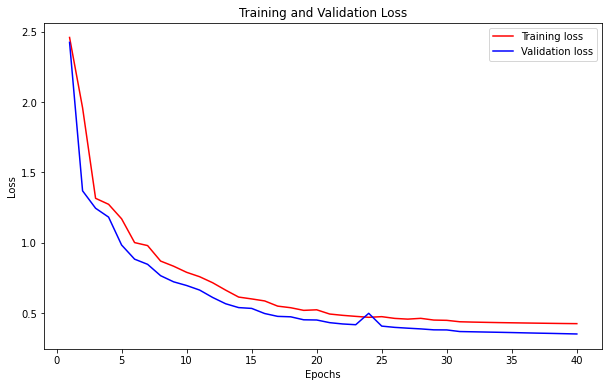

In [7]:
plot_loss_curves(train_losses, val_losses)

In [9]:
mdl = model.to('cpu')

### Load old

In [10]:
#mdl.load_state_dict(torch.load('networks/RVQL1rawL1L2melLw_32res_96batch_1/RVQl1rawLw_model_epoch_40.pth')['model_state_dict'])


<All keys matched successfully>

# Audio Test

In [11]:
import IPython

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_audio_signals(original_signal, reconstructed_signal, sample_rate=24000):
    """
    Plot the original and reconstructed audio signals vertically.
    
    Args:
        original_signal (np.ndarray): The original audio signal.
        reconstructed_signal (np.ndarray): The reconstructed audio signal.
        sample_rate (int): The sample rate of the audio signals.
        
    Returns:
        None
    """
    min_length = min(len(original_signal), len(reconstructed_signal))
    time = np.arange(min_length) / sample_rate
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
    
    axs[0].plot(time, original_signal[:min_length], color='b', label='Original Signal')
    axs[0].set_title('Original Audio Signal')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(time, reconstructed_signal[:min_length], color='r', alpha=0.7, label='Reconstructed Signal')
    axs[1].set_title('Reconstructed Audio Signal')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import random

def rfd(directory):
    """
    Selects a file or directory at random from the given directory.
    
    Parameters:
        directory (str): Path to the directory containing files and/or directories.
    
    Returns:
        str: Path to the randomly selected file or directory.
    """
    entries = [e for e in os.listdir(directory) if os.path.exists(os.path.join(directory, e))]
    if not entries:
        raise ValueError("No files or directories found in the directory.")
    
    return os.path.join(directory, random.choice(entries))

# # Example usage:
# directory_path = "wav48/1/"
# random_file = rfd(directory_path)
# print("Randomly selected file:", random_file)

# Test Audio

In [12]:
import soundfile as sf


a = rfd(datadir+"orig_train24khz")
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
#d1 = mdl.decoder(mdl.encoder(d)).flatten().detach().numpy()
d1 = mdl(d)[0].flatten().detach().numpy()

In [13]:
import soundfile as sf


a = rfd(datadir+"orig_train24khz")
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
#d1 = mdl.decoder(mdl.encoder(d)).flatten().detach().numpy()   #uncomment this if not using quantization
d1 = mdl(d)[0].flatten().detach().numpy()                      #Comment this is not using quantization

/home/archisman/DDL/encodec-main/encodec/quantization/core_vq.py:308: UserWarning: When using RVQ in training model, first check https://github.com/facebookresearch/encodec/issues/25 . The bug wasn't fixed here for reproducibility.
  warnings.warn('When using RVQ in training model, first check '


In [14]:
IPython.display.Audio(a1,rate=24000)

In [15]:
IPython.display.Audio(d1,rate=24000)

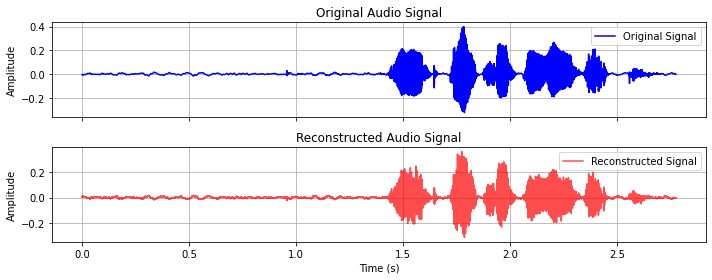

In [17]:
plot_audio_signals(a1,d1,24000)

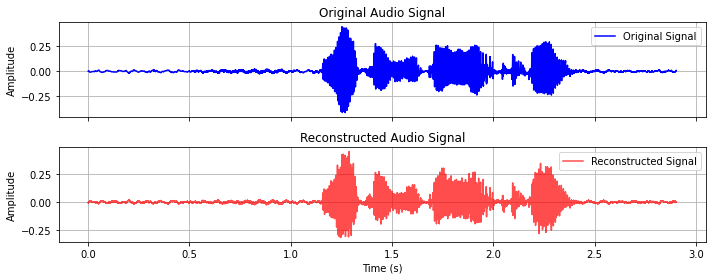

In [19]:
plot_audio_signals(a1,d1,24000)

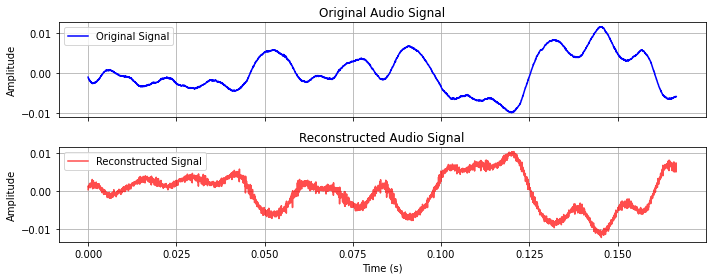

In [18]:
plot_audio_signals(a1[1000:5000],d1[1000:5000],24000)

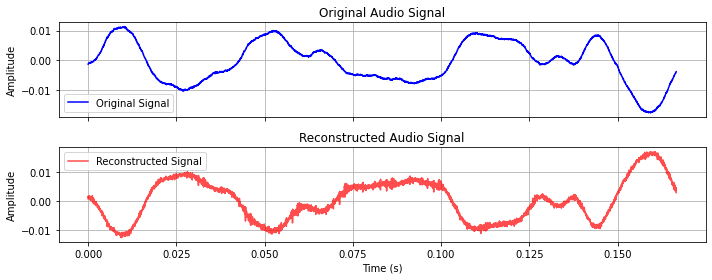

In [18]:
plot_audio_signals(a1[1000:5000],d1[1000:5000],24000)

# Unknown Speaker

In [19]:
import soundfile as sf


a = rfd((rfd(datadir+"orig_test24khz")))
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
#d1 = mdl.decoder(mdl.encoder(d)).flatten().detach().numpy()
d1 = mdl(d)[0].flatten().detach().numpy()

In [20]:
IPython.display.Audio(a1,rate=24000)

In [21]:
IPython.display.Audio(d1,rate=24000)

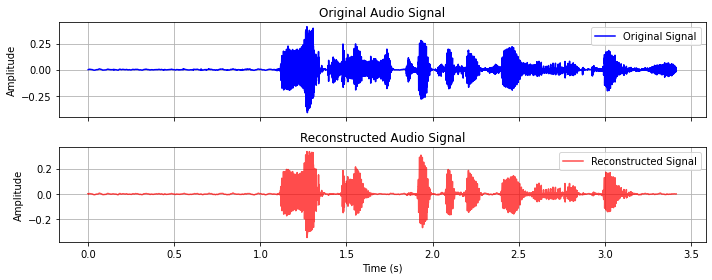

In [38]:
plot_audio_signals(a1,d1,24000)

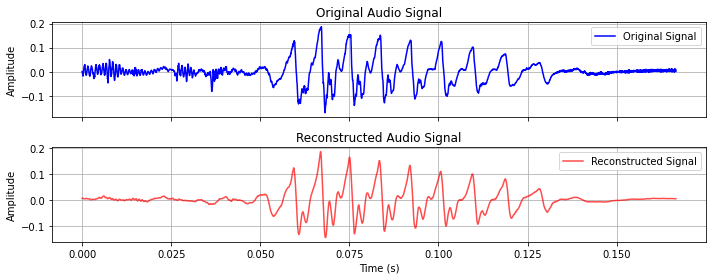

In [39]:
plot_audio_signals(a1[21*24000//10+1000:21*24000//10+5000],d1[21*24000//10+1000:21*24000//10+5000],24000)

In [7]:
model=model.to('cpu');

# Train Audio

In [30]:
import soundfile as sf


a = rfd(datadir+"orig_train24khz")
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
d1 = model.decoder(model.encoder(d)).flatten().detach().numpy()

In [31]:
IPython.display.Audio(a1,rate=24000)

In [32]:
IPython.display.Audio(d1,rate=24000)

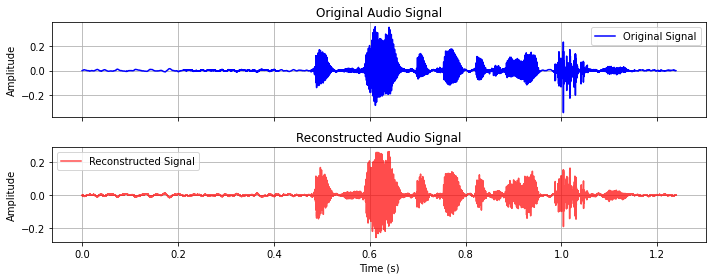

In [33]:
plot_audio_signals(a1,d1,48000)